In [1]:
# Classification of points (images) lying on one side of the curve - the decision boundary:
#
#
#                  (1,3)                (3,3)
#                       o-----------------o
#                      /                   \      class 0
#                     /                     \
#                    /                       \
#                   /                         \
# -----------------o  (-1,1)            (5,1)  o-------------------------------------------
#
#                              class 1

In [2]:
import time
import os.path
import pdb
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v1 as tf
print(tf.__version__)
# if tensorflow2 use tf.compat.v1. apart tf. (see classification2 script)
tf.compat.v1.disable_eager_execution()

2.19.0



In [3]:
num_of_features = 2
num_of_epochs = 1000
num_to_show = 50

sess = tf.InteractiveSession()

x = tf.placeholder(tf.float32, shape=[None, num_of_features])  # place for input vectors
y_ = tf.placeholder(tf.float32, shape=[None, 1])               # place for desired output of ANN

### Analytical version
(See more: https://d2l.ai/chapter_linear-regression/linear-regression.html )

In [4]:
my_tensor = tf.constant([
    [0.0,  -1.0,  0.0,  1.0],  # x1 coefficients for func1, func2, func3, func4
    [ 1.0,  1.0,  1.0,  1.0]   # x2 coefficients for func1, func2, func3, func4
],dtype=float)
IW_a = tf.Variable(my_tensor)                                # 1-st level weights
b1_a = tf.Variable(tf.constant([-2.0, -1.0, -3.0, -6.0],dtype=float))      # 1-st level biases -||-

In [5]:
# output values from 1-st level:
h1 = tf.cast(tf.less(tf.matmul(x, IW_a) + b1_a, 0.0), tf.float32)
                                                             # use sharp threshold activation function like:
                                                             #
                                                             #          ---------
                                                             #          |
                                                             #   --------

In [6]:
inside_trapezoid = tf.reduce_min(h1[:, 1:], axis=1, keepdims=True)
below_1 = tf.expand_dims(h1[:, 0], axis=1)  # warunek x2 < 1

y_a = tf.maximum(inside_trapezoid, below_1)
y = y_a

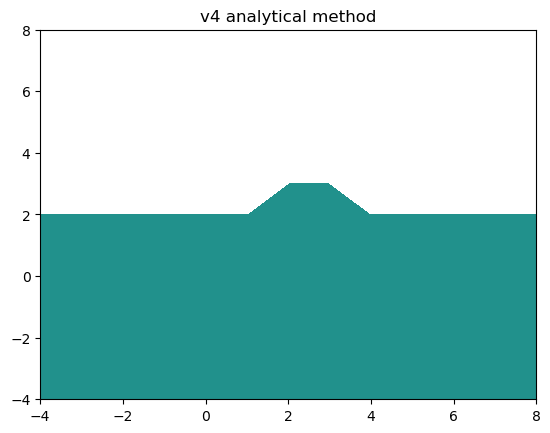

In [7]:
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)

X1, X2 = np.meshgrid(np.linspace(-4, 8, 120), np.linspace(-4,8, 120))  # grid of points in 2D plane
P = np.stack((X1.flatten(),X2.flatten()), axis=1)                    # points formated for ANN input
Y = sess.run(y_a, feed_dict={x: P})                                    # ANN outputs for flatten grid  points
Z = np.reshape(Y,X1.shape)                                           # reshaping to shape of grid
plt.contourf(X1, X2, Z, levels=[0.5, 1.0])                           # curve for level=0.5 - a decision boundary, shaded class 1 area
plt.title('v4 analytical method')
plt.show()

### Trainable version

In [8]:
nneu = [30, 1]                     # number of neurons in subsequent levels of ANN
                                         # number of neurons in the last layer == 1
num_of_epochs = 1000
num_to_show = 50

sess = tf.compat.v1.InteractiveSession()

tf.compat.v1.disable_eager_execution()

ERROR:tensorflow:An interactive session is already active. This can cause out-of-memory errors or some other unexpected errors (due to the unpredictable timing of garbage collection) in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s). Please use `tf.Session()` if you intend to productionize.


In [9]:
x = tf.compat.v1.placeholder(tf.float32, shape=[None, num_of_features])  # place for input vectors
y_ = tf.compat.v1.placeholder(tf.float32, shape=[None, 1])
IW = tf.Variable(tf.random.truncated_normal([num_of_features, nneu[0]], stddev=0.1))  # 1-st level weights initialized with normal distribution
b1 = tf.Variable(tf.constant(0.1, shape=[nneu[0]]))                                    # 1-st level biases -||-

In [10]:
h1 = h1 = tf.nn.tanh(tf.matmul(x, IW) + b1)            # use continuous version of activation function

In [11]:
LW21 = tf.Variable(tf.random.truncated_normal([nneu[0],nneu[1]], stddev=0.1))               # 2-nd level weights values
           # 2-nd level weights values
b2 = tf.Variable(tf.zeros([nneu[1]]))                                                                                    # 2-nd level bias values

# LW32 = .................           # maybe 3-d layer
# b3 = ...................

In [12]:
a2 = tf.matmul(h1, LW21) + b2                                   # weighted sum of signals from 1-st level
if len(nneu) == 2:
    y_lin = a2                                                  # output of network == output from 2-nd level
if len(nneu) > 2:
    h2 = tf.tanh(a2)                               # output from 2-nd level with nonlinear activation
    LW32 = tf.Variable(tf.random.truncated_normal([nneu[1],nneu[2]], stddev=0.1))   # 3-nd level weights values
    b3 = tf.Variable(tf.zeros([nneu[2]]))                                           # 3-nd level bias values
    y_lin = tf.matmul(h2, LW32) + b3

#y = tf.nn.sigmoid(y_lin)                # output from ANN (single value using sigmoidal act.funct in range (0,1))
y = tf.nn.sigmoid(y_lin)
                               # linear version of last layer of network (e.g. for regression)


In [13]:
mean_square_error = tf.reduce_mean(tf.reduce_sum((y_ - y)*(y_ - y), reduction_indices=[1]))          # MSE loss function
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y) + y*tf.log(y_+0.001), reduction_indices=[1])) # full cross-entropy loss function

train_step = tf.compat.v1.train.AdamOptimizer(learning_rate=0.05).minimize(mean_square_error)                                                                             # You can choose loss function

init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)


In [14]:
points = np.array([[-2,2],[-1,2],[0,3],[1,4],[2,4],[3,4],[4,3],[5,2],[6,2],[7,2],[6,7],[7,4],[2,6],[-2,6],
                   [-2,0],[-1,0],[0,1],[1,2],[2,2],[3,2],[4,1],[5,0],[6,0],[7,0],[6,-1],[2,1],[2, -1],[-2,-2]
                   ], dtype=float)
class_labels = np.transpose(np.array([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1]], dtype = int))
num_of_examples, num_of_features = points.shape
range_min = np.amin(points,axis=0)       # for plotting
range_max = np.amax(points,axis=0)
print ("number of examples = "+str(num_of_examples)+ ", number of features = "+str(num_of_features) )

ind0 = np.where(class_labels == 0)       # indexes of examples which belong to class 0
ind1 = np.where(class_labels == 1)



number of examples = 28, number of features = 2


#### The training process

In [15]:
for epoch in range(num_of_epochs+1):
    sess.run(train_step, feed_dict={x: points, y_: class_labels})     # ses.run using dictionary with whole training data
    if epoch % num_to_show == 0:
        wrong_prediction = tf.greater(tf.abs(y-y_),0.5)               # vector of classification errors
        error = tf.reduce_mean(input_tensor=tf.cast(wrong_prediction, tf.float32)) # mean classification error

        print("\nafter "+str(epoch)+" epoch")
        print("MSE error = " + str(sess.run(mean_square_error, feed_dict={x: points, y_: class_labels})))
        print("Cross Entropy error = " + str(sess.run(cross_entropy, feed_dict={x: points, y_: class_labels})))
        print("training classification error = " + str(sess.run(error, feed_dict={x: points, y_: class_labels})))




after 0 epoch
MSE error = 0.22279194
Cross Entropy error = 1.5519826
training classification error = 0.39285713

after 50 epoch
MSE error = 0.0018280529
Cross Entropy error = 0.115159206
training classification error = 0.0

after 100 epoch
MSE error = 0.00053294847
Cross Entropy error = 0.056838654
training classification error = 0.0

after 150 epoch
MSE error = 0.0002736701
Cross Entropy error = 0.040530305
training classification error = 0.0

after 200 epoch
MSE error = 0.00016838885
Cross Entropy error = 0.031603135
training classification error = 0.0

after 250 epoch
MSE error = 0.000114789254
Cross Entropy error = 0.02596715
training classification error = 0.0

after 300 epoch
MSE error = 8.363744e-05
Cross Entropy error = 0.022075465
training classification error = 0.0

after 350 epoch
MSE error = 6.3857675e-05
Cross Entropy error = 0.01922357
training classification error = 0.0

after 400 epoch
MSE error = 5.047813e-05
Cross Entropy error = 0.017042825
training classification e

#### Drawing decision boundary

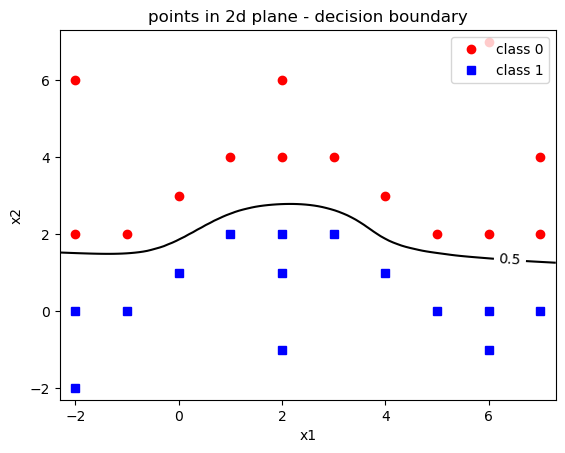

In [16]:
# drawing points:
line1 = plt.plot(np.transpose(points[ind0[0],0]), np.transpose(points[ind0[0],1]), 'ro', label = 'class 0')
line2 = plt.plot(np.transpose(points[ind1[0],0]), np.transpose(points[ind1[0],1]), 'bs', label = 'class 1')
plt.title("points in 2d plane - decision boundary")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()

# drawing decision boundary:
X1, X2 = np.meshgrid(np.linspace(range_min[0]- 0.3, range_max[0]+0.3, 120), np.linspace(range_min[1]- 0.3, range_max[1]+0.3, 80))  # grid of points in 2D plane
P = np.stack((X1.flatten(),X2.flatten()), axis=1)                    # points formated for ANN input
Y = sess.run(y, feed_dict={x: P})                                    # ANN outputs for flatten grid  points
Z = np.reshape(Y,X1.shape)                                           # reshaping to shape of grid
contour = plt.contour(X1, X2, Z, levels=[0.5], colors='black')
plt.clabel(contour, inline=True)                # curve for level=0.5 - a decision boundary
plt.show()

#### Drawing 3D mesh

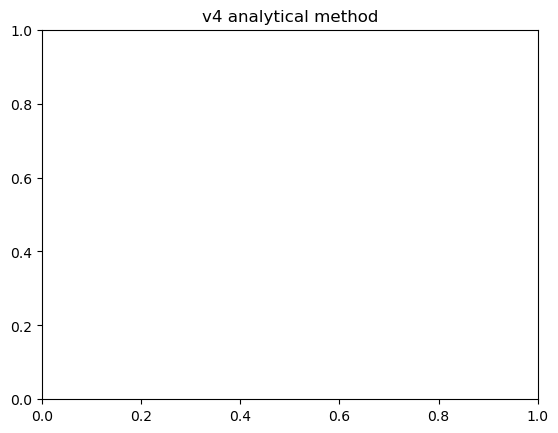

In [17]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(X1, X2, Z, rstride=1, cstride=1, cmap=cm.viridis)
plt.title('v4 analytical method')
plt.show()